In [405]:
from calendar import c
from collections import defaultdict
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from tqdm import tqdm
from typing import List, Tuple, Callable
import numpy as np
from copy import deepcopy

In [380]:
DEVICE_REPORT_PRODUCT_CODES = set([
    'MAF',
    'NIQ',
    'PNY',
    'NIV',
])

FOI_TEXT_SEARCH_STRINGS = [
    'PATIENT EXPIRED',
    'PATIENT DIED',
    'SUBSEQUENTLY EXPIRED',
    'DECEDENT',
    'TIME OF DEATH'
    'PATIENTS EXPIRED',
    'PATIENTS DIED',
    'TIME OF DEATH',
    'PATIENT LATER EXPIRED'
]
# Misreports: event_type in ('M', 'IN')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            all 4 devices

# All death reports: 
#         event_type in ('M', 'IN', 'D')
#         foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            all 4 devices

EVENT_TYPES = set([
    'M', 'IN', 'D'
])
DEVICE_FILENAMES = [join('data/device-data', f) for f in listdir('data/device-data') if isfile(join('data/device-data', f))]
FOI_FILENAMES = [join('data/foi-data', f) for f in listdir('data/foi-data') if isfile(join('data/foi-data', f))]
MDR_FILENAMES = ['data/mdrfoiThru2020.txt']
OUTPUT_FILE = 'all-reports.txt'
OUTPUT_LOG = 'misreports_stats.txt'
DEVICE_FILENAMES.sort()
FOI_FILENAMES.sort()

In [411]:
class DataTable:
    def __init__(self, primary_key='MDR_REPORT_KEY'):
        self.primary_key = primary_key
        self.data = defaultdict(list)
        self.column_names = []
    
    def _passed_column_filters(
        self,
        row: str,
        column_filters: list[tuple[str, Callable[[str], bool]]],
        column_indexes
    ):
        for column_name, func in column_filters:
            column_index = column_indexes[column_name]
            if column_index >= len(row):
                return False
            if not func(row[column_index]):
                return False
        return True
    
    def join_dataset(
        self,
        filenames: list[str],
        select_column_names: list[str],
        column_filters: list[tuple[str, Callable[[str], bool]]]
    ):
        self.column_names += select_column_names
        
        for filename in filenames:
#             print(f'Parsing {filename}')
            with open(filename, encoding="latin-1") as file:
                read_header = False

                for line in tqdm(file):
                    row = line.strip().split('|')
                    key = row[0]
                    if not read_header:
                        column_indexes = {c: row.index(c) for c in row}
                        read_header = True
                        continue

                    if not self._passed_column_filters(row, column_filters, column_indexes):
                        continue
                    
                    selected_columns = [row[column_indexes[c]] for c in select_column_names]
                    
                    if len(self.data[key]) >= len(self.column_names):
                        # TODO: Handle duplicate key
                        continue
                        
                    for _ in range(len(self.column_names) - len(self.data[key]) - len(selected_columns)):
                        self.data[key].append(None)
                    self.data[key] += selected_columns
        print(len(self.data))
        self.remove_imcomplete_entries()
    
    def remove_imcomplete_entries(self):
        for key in list(self.data.keys()):
            if None in self.data[key]:
                del self.data[key]
            elif len(self.data[key]) < len(self.column_names):
                del self.data[key]
                
    def parse_mdy_dates(self, column_name):
        column = self.column_names.index(column_name)
        for key in self.data:
            date = self.data[key][column]
            if isinstance(date, datetime):
                continue

            if not date:
                self.data[key][column] = None
                continue

            components = date.split('/')
            if len(components) != 3:
                self.data[key][column] = None

            month, day, year = components
            self.data[key][column] = datetime(int(year), int(month), int(day))

    def count_by_group_over_time(self, date_fn, group_fn):
        group_counts = defaultdict(lambda: defaultdict(int))
        for key in self.data:
            date = date_fn(self.data[key])
            group = group_fn(self.data[key])
            if date and group:
                group_counts[group][date] += 1
        return group_counts





In [382]:
data_table = DataTable()
data_table.join_dataset(
    DEVICE_FILENAMES, 
    ['DEVICE_REPORT_PRODUCT_CODE'],
    [('DEVICE_REPORT_PRODUCT_CODE', lambda c: c in DEVICE_REPORT_PRODUCT_CODES)]
)
data_table.join_dataset(
    MDR_FILENAMES,
    ['DATE_OF_EVENT', 'EVENT_TYPE'],
    [('EVENT_TYPE', lambda e: e in EVENT_TYPES)]
)
data_table.parse_mdy_dates('DATE_OF_EVENT')
data_table.remove_imcomplete_entries()


446875it [00:00, 582154.30it/s]
487726it [00:00, 570677.98it/s]
682274it [00:01, 583272.78it/s]
863778it [00:01, 580814.83it/s]
862586it [00:01, 572618.76it/s]
868366it [00:01, 553987.44it/s]
938694it [00:01, 564543.80it/s]
1050345it [00:01, 557681.98it/s]
1333413it [00:02, 562320.21it/s]
1567568it [00:02, 569619.77it/s]


79136


10800980it [00:59, 180911.30it/s]


10643909


In [438]:
def generate_datetimes(include_months=True):
    datetimes = []

    for year in range(2011, 2021):
        datetimes.append(datetime(year, 1, 1))

        if include_months:
            for month in range(2, 13 if year < 2020 else 3):
                datetimes.append(datetime(year, month, 1))

    return datetimes

def select_and_group_by_month(entry, date_of_event_index):
    date = entry[date_of_event_index]
    if datetime(2011, 1, 1) <= date < datetime(2020, 3, 1):
        return datetime(date.year, date.month, 1)
    else:
        return None

def select_and_group_by_year(entry, date_of_event_index):
    date = entry[date_of_event_index]
    if datetime(2011, 1, 1) <= date < datetime(2020, 3, 1):
        return datetime(date.year, 1, 1)
    else:
        return None

def maf_filter(entry, product_code_index, val):
    return val if entry[product_code_index] == 'MAF' else None

def niq_filter(entry, product_code_index, val):
    return val if entry[product_code_index] == 'NIQ' else None

def maf_niq_filter(entry, product_code_index, val):
    return val if entry[product_code_index] in ('MAF', 'NIQ') else None

def pny_filter(entry, product_code_index, val):
    return val if entry[product_code_index] == 'PNY' else None

def niv_filter(entry, product_code_index, val):
    return val if entry[product_code_index] == 'NIV' else None

def product_code_to_device_name(code):
    if code == 'MAF': return 'BMS'
    if code == 'NIQ': return 'DES'
    if code == 'PNY': return 'BAS'
    return code

def expand_event_type(code):
    if code == 'D': return 'Death'
    if code == 'IN': return 'Injury'
    if code == 'M': return 'Malfunction'
    return code

def format_product_code_event_type(r, code_index, event_index):
    return f'{product_code_to_device_name(r[code_index])}, {expand_event_type(r[event_index])}'


def malfunction_death_filter(entry, event_type_index, val):
    return val if entry[event_type_index] in ('M', 'D') else None

def malfunction_injury_filter(entry, event_type_index, val):
    return val if entry[event_type_index] in ('M', 'IN') else None

def malfunction_filter(entry, event_type_index, val):
    return val if entry[event_type_index] == 'M' else None

def plot_scatter_group_counts_by_time(
    group_counts,
    y_margin_top=7,
    include_zeros=True,
    group_by_month=True,
    output_file=None
):
    markers = ['o', '^', 'v',  'p', '<', '>', 's',  '*', 'H', 'D', 'd', 'P', 'h', ]
    linestyles = ['-', '--', '-.', ':' ]
    max_y = 0
    if output_file:
        with open(output_file, 'w') as file:
            file.write('GROUP|DATE|VALUE')

    for i, group in enumerate(group_counts):
        dates = generate_datetimes(include_months=group_by_month)
        reports_by_date = group_counts[group]
        if include_zeros:
            for d in dates:
                if d not in reports_by_date:
                    reports_by_date[d] = 0

        group_total = sum(reports_by_date.values())

        x, y = zip(*sorted(reports_by_date.items()))
        max_y = max(max_y, max(y))
        ordinal_x = [xx.toordinal() for xx in x]
        slope, intercept, r_value, p_value, std_err = stats.linregress(ordinal_x, y)
        predict_y = intercept + slope * np.array(ordinal_x)
        plt.plot(
            x, predict_y,
            label=f'{group}, r={r_value:.2f}',
            linestyle=linestyles[i % len(linestyles)],
        )
        plt.scatter(
            x, y,
            label=f'{group}, {group_total}',
            marker=markers[i % len(markers)],
        )
        if output_file:
            with open(output_file, 'a') as file:
                for xx, yy in zip(x, y):
                    file.write(f'{xx.strftime("%Y-%m-%d"))
                
    plt.ylim(0, max_y*(1 + y_margin_top/100))

    plt.xlabel('Time')
    plt.ylabel('Count per Month')
    plt.legend()


In [395]:
date_of_event_index = data_table.column_names.index('DATE_OF_EVENT')
product_code_index = data_table.column_names.index('DEVICE_REPORT_PRODUCT_CODE')
event_type_index = data_table.column_names.index('EVENT_TYPE')

In [396]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})

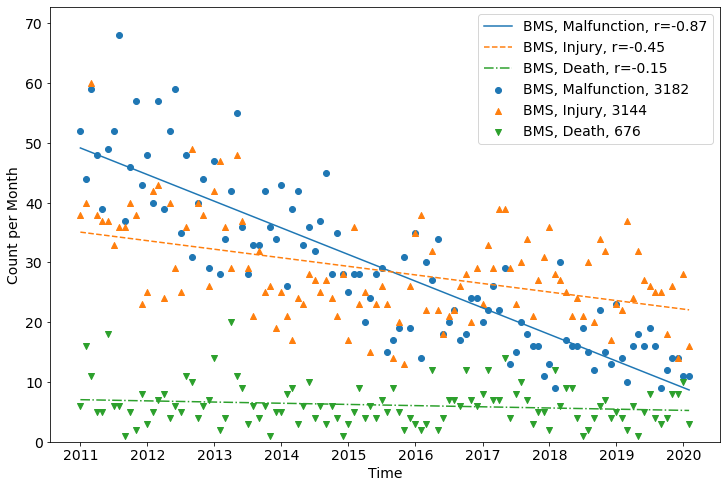

In [397]:
# MAF ~ BMS
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: maf_filter(
        r,
        product_code_index, 
        format_product_code_event_type(r, product_code_index, event_type_index)
    )
)
plot_scatter_group_counts_by_time(group_counts)

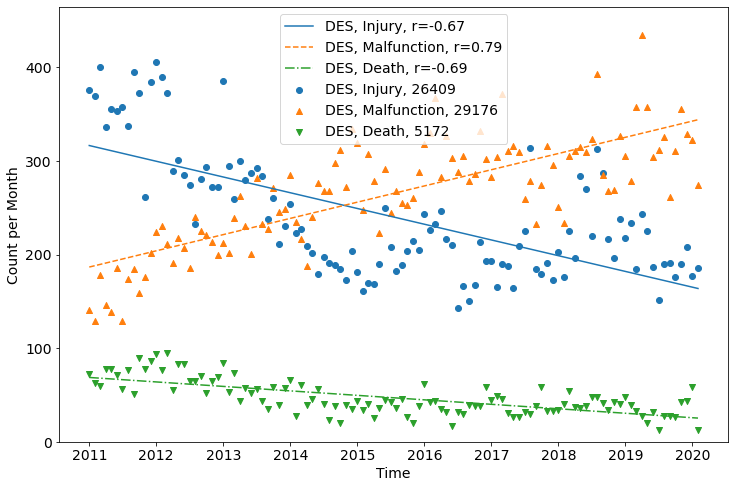

In [398]:
# NIQ ~ DES
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: niq_filter(
        r,
        product_code_index, 
        format_product_code_event_type(r, product_code_index, event_type_index)
    )
)
plot_scatter_group_counts_by_time(group_counts)

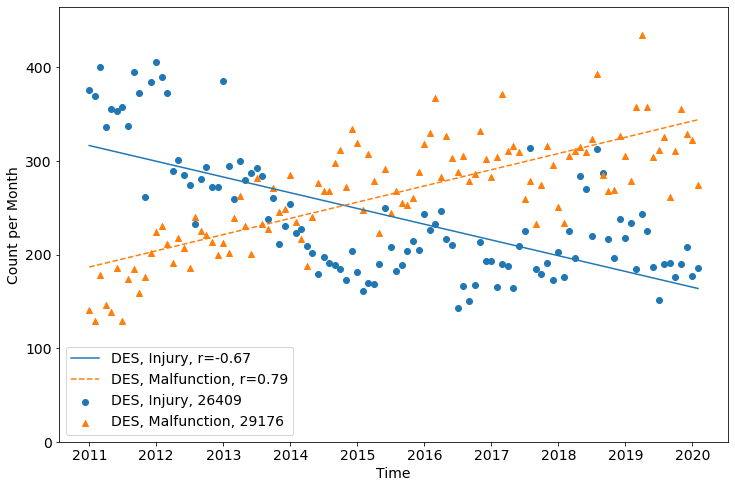

In [399]:
# NIQ ~ DES
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: malfunction_injury_filter(
        r, event_type_index,     
        niq_filter(r, product_code_index, 
                   format_product_code_event_type(r, product_code_index, event_type_index))
    )
)
plot_scatter_group_counts_by_time(group_counts)

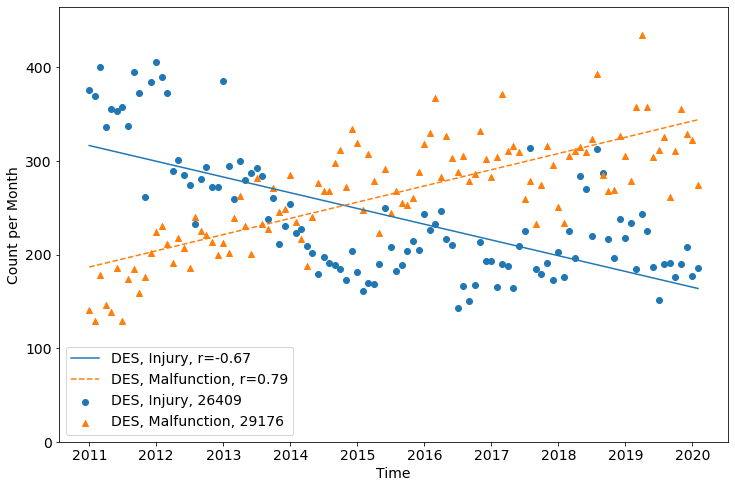

In [440]:
# NIQ ~ DES
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: malfunction_injury_filter(
        r, event_type_index,     
        niq_filter(r, product_code_index, format_product_code_event_type(r, product_code_index, event_type_index))
    )
)
plot_scatter_group_counts_by_time(group_counts)

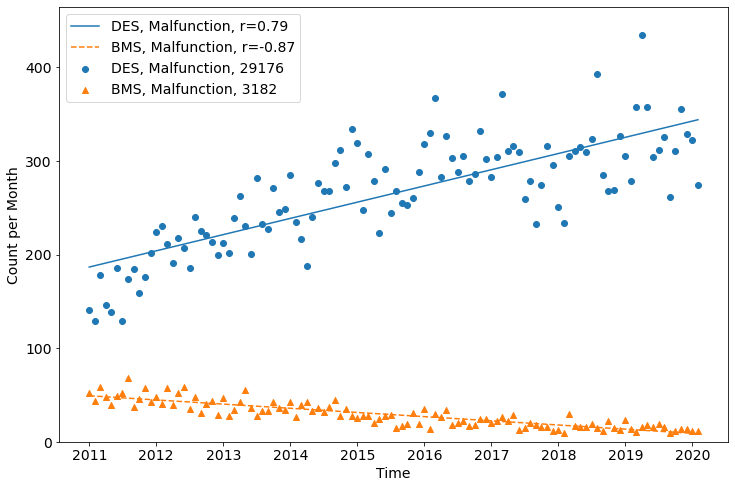

In [439]:
# NIQ ~ DES, MAF ~ BMS, Malfunction
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: malfunction_filter(
        r, event_type_index,     
        maf_niq_filter(r, product_code_index, format_product_code_event_type(r, product_code_index, event_type_index))
    )
)
plot_scatter_group_counts_by_time(group_counts)

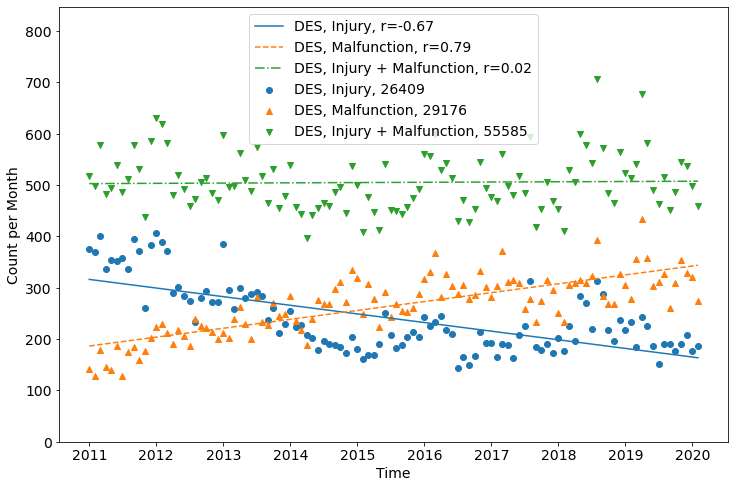

In [401]:
# NIQ, M and IN
separate_group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: malfunction_injury_filter(
        r, event_type_index,     
        niq_filter(
            r, product_code_index,
            format_product_code_event_type(r, product_code_index, event_type_index)
        )
    )
)
combined_group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: malfunction_injury_filter(
        r, event_type_index,     
        niq_filter(
            r, product_code_index,
            f'{product_code_to_device_name(r[product_code_index])}, Injury + Malfunction'
        )
    )
)
plot_scatter_group_counts_by_time(
    {**separate_group_counts, **combined_group_counts},
    y_margin_top=20
)

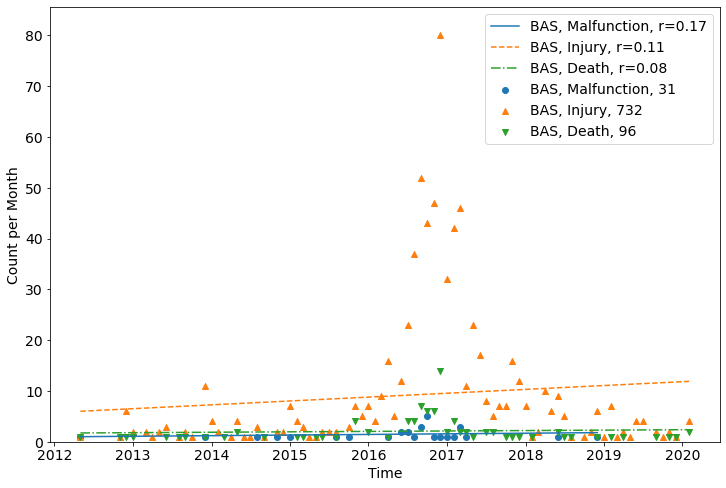

In [402]:
# PNY
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: #malfunction_death_filter(r, event_type_index, 
        pny_filter(
            r,
            product_code_index, 
            format_product_code_event_type(r, product_code_index, event_type_index)
        #)
    )
)
plot_scatter_group_counts_by_time(group_counts, include_zeros=False)

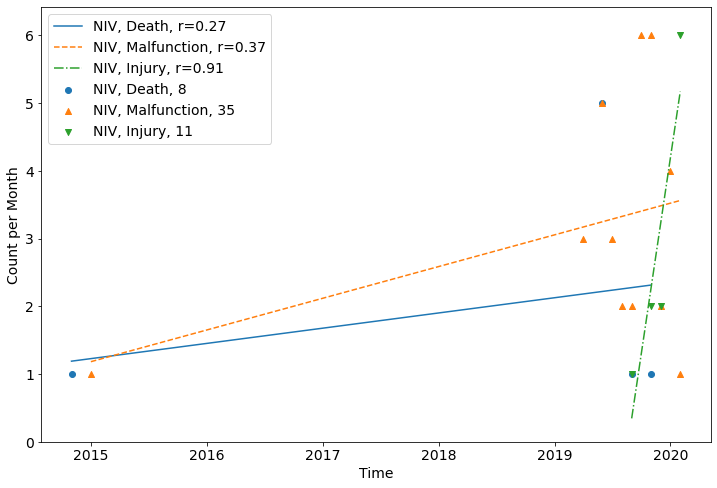

In [403]:
# NIV
group_counts = data_table.count_by_group_over_time(
    lambda r: select_and_group_by_month(r, date_of_event_index),
    lambda r: #malfunction_death_filter(r, event_type_index, 
        niv_filter(
            r,
            product_code_index, 
            format_product_code_event_type(r, product_code_index, event_type_index)
        #)
    )
)
plot_scatter_group_counts_by_time(group_counts, include_zeros=False)

In [416]:
misreport_datatable = deepcopy(data_table)

def foi_text_contains_a_search_string(text):
    for search_string in FOI_TEXT_SEARCH_STRINGS:
        if search_string in text:
            return True
    return False

misreport_datatable.join_dataset(
    FOI_FILENAMES, 
    ['FOI_TEXT'],
    [('FOI_TEXT', lambda t: foi_text_contains_a_search_string(t))]
)

1it [00:00, 11335.96it/s]
1040282it [00:04, 251857.60it/s]
1167623it [00:04, 252794.92it/s]
1609334it [00:06, 262582.59it/s]
1948387it [00:07, 255101.84it/s]
2074008it [00:08, 249334.41it/s]
2180342it [00:08, 246965.10it/s]
2361287it [00:09, 237252.62it/s]
2560831it [00:09, 256775.13it/s]
2828292it [00:10, 267741.85it/s]
3038614it [00:11, 273979.30it/s]


154804


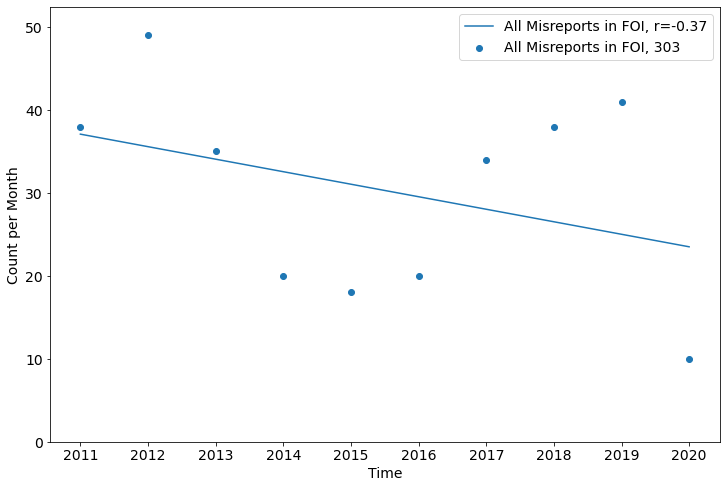

In [426]:
# Misreports: event_type in ('M', 'IN')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            all 4 devices
group_counts = misreport_datatable.count_by_group_over_time(
    lambda r: select_and_group_by_year(r, date_of_event_index),
    lambda r: malfunction_injury_filter(
        r, event_type_index, 'All Misreports in FOI'
    )
)
plot_scatter_group_counts_by_time(group_counts, group_by_month=False)

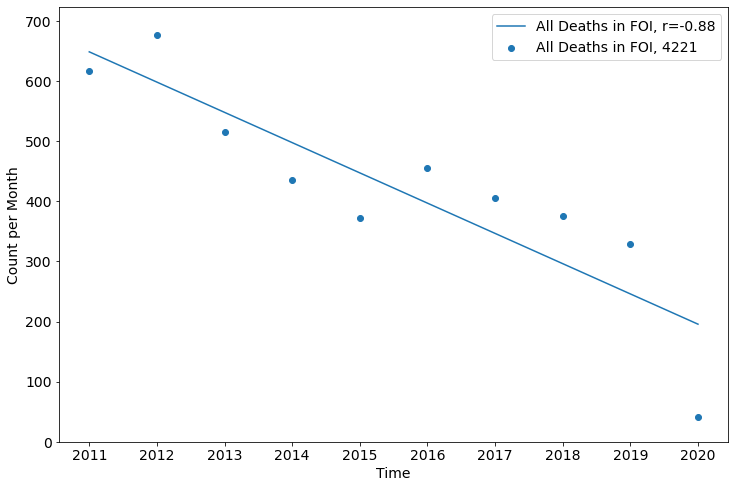

In [427]:
# All deaths in FOI: event_type in ('M', 'IN', 'D')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            all 4 devices
group_counts = misreport_datatable.count_by_group_over_time(
    lambda r: select_and_group_by_year(r, date_of_event_index),
    lambda r: 'All Deaths in FOI'
)
plot_scatter_group_counts_by_time(group_counts, group_by_month=False)
#         niq_filter(
#             r, product_code_index, 
#             format_product_code_event_type(r, product_code_index, event_type_index)
#         )

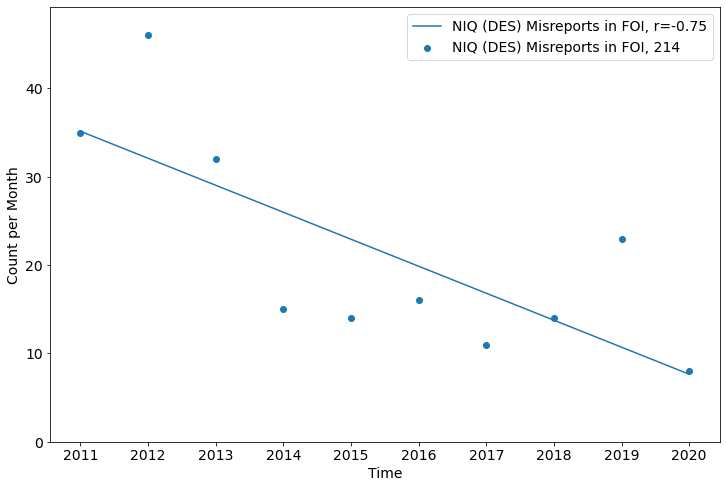

In [430]:
# Misreports: event_type in ('M', 'IN')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            NIQ device
group_counts = misreport_datatable.count_by_group_over_time(
    lambda r: select_and_group_by_year(r, date_of_event_index),
    lambda r: niq_filter(r, product_code_index, 
        malfunction_injury_filter(
            r, event_type_index, 'NIQ (DES) Misreports in FOI'
        )
    )
)
plot_scatter_group_counts_by_time(group_counts, group_by_month=False)

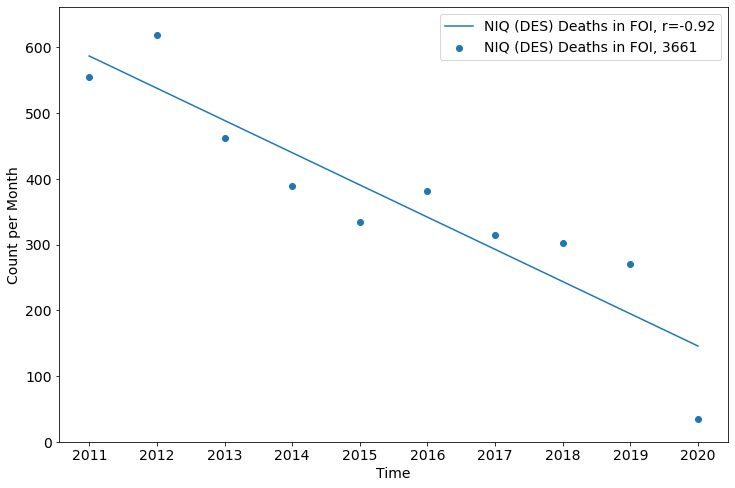

In [433]:
# Misreports: event_type in ('M', 'IN', 'D')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            NIQ device
group_counts = misreport_datatable.count_by_group_over_time(
    lambda r: select_and_group_by_year(r, date_of_event_index),
    lambda r: niq_filter(
        r, product_code_index, 'NIQ (DES) Deaths in FOI'
    )
)
plot_scatter_group_counts_by_time(group_counts, group_by_month=False)

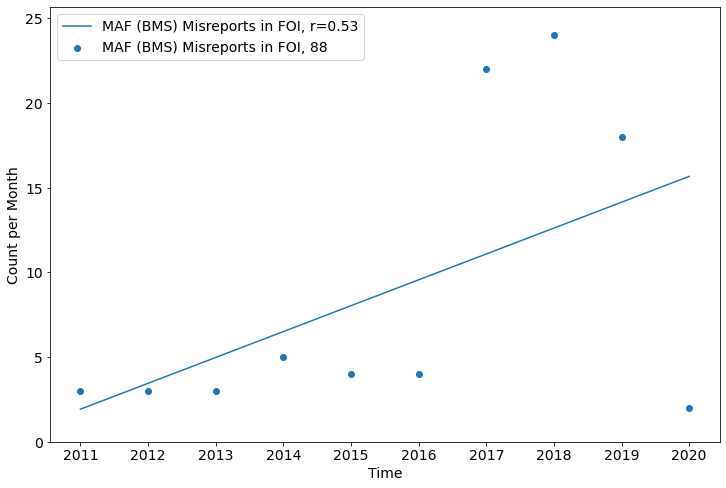

In [434]:
# Misreports: event_type in ('M', 'IN')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            MAF device
group_counts = misreport_datatable.count_by_group_over_time(
    lambda r: select_and_group_by_year(r, date_of_event_index),
    lambda r: maf_filter(r, product_code_index, 
        malfunction_injury_filter(
            r, event_type_index, 'MAF (BMS) Misreports in FOI'
        )
    )
)
plot_scatter_group_counts_by_time(group_counts, group_by_month=False)

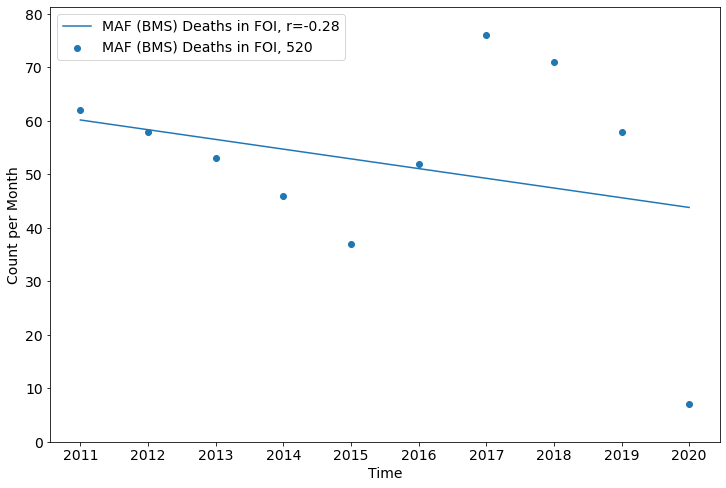

In [436]:
# Misreports: event_type in ('M', 'IN', 'D')
#            foi_text contains one of (FOI_TEXT_SEARCH_STRINGS)
#            MAF device
group_counts = misreport_datatable.count_by_group_over_time(
    lambda r: select_and_group_by_year(r, date_of_event_index),
    lambda r: maf_filter(
        r, product_code_index, 'MAF (BMS) Deaths in FOI'    
    )
)
plot_scatter_group_counts_by_time(group_counts, group_by_month=False)